In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import time
%matplotlib inline  
import sys
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/jz2308/bus-Capstone')

# these two modules are homemade
import gtfs
import arrivals
import ttools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

In [13]:
# get all the schedule data. (subset can be created later)
trips = gtfs.load_trips('2015-12-03','gtfs/')
stops = gtfs.load_stops('2015-12-03','gtfs/')
stop_times, tz_sched = gtfs.load_stop_times('2015-12-03','gtfs/')
tcal=gtfs.TransitCalendar('2015-12-03')
thurs_services = tcal.get_service_ids('2015-12-03')
thurs_trips = trips.service_id.isin(thurs_services)
thurs_stops = stop_times.reset_index().set_index('trip_id').loc[thurs_trips]
print 'Finished loading GTFS data.'

Finished loading GTFS data.


In [14]:
interpolated = pd.read_csv('2015-12-03_interpolated.csv')

In [15]:
interpolated.head()

,route,trip_id,trip_date,vehicle_id,stop_id,interpolated_arrival_time
0,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,402805,0 days 06:14:08.112401
1,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,405057,0 days 06:15:05.545780
2,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,403416,0 days 06:16:58.526210
3,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,402809,0 days 06:17:25.226045
4,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,402811,0 days 06:18:36.819142


In [16]:
interpolated['interpolated_arrival_time'] = pd.to_timedelta(interpolated['interpolated_arrival_time'])

In [17]:
interpolated = interpolated.merge(stop_times[['arrival_time','stop_sequence']],how='left',left_on=['trip_id','stop_id'],right_index=True)

In [18]:
# bools = interpolated.duplicated(subset=['route','trip_id','trip_date','vehicle_id','stop_id'],take_last=False) + interpolated.duplicated(subset=['route','trip_id','trip_date','vehicle_id','stop_id'],take_last=True)
# interpolated[bools].sort(['route','trip_id','trip_date','vehicle_id']).shape

In [19]:
interpolated.set_index(['route','trip_id','trip_date','vehicle_id','stop_sequence','stop_id'],inplace=True)

## Get mean travel times based interpolations between stops

In [20]:
travel_times = interpolated['interpolated_arrival_time']/ttools.datetime.timedelta(seconds=1)

In [21]:
travel_times.head()

route          trip_id                            trip_date   vehicle_id     stop_sequence  stop_id
MTA NYCT_M101  OH_D5-Weekday-SDon-036500_M101_38  2015-12-03  MTA NYCT_5879  2              402805     22448.112401
                                                                             3              405057     22505.545780
                                                                             4              403416     22618.526210
                                                                             5              402809     22645.226045
                                                                             6              402811     22716.819142
Name: interpolated_arrival_time, dtype: float64

In [22]:
# travel_times = travel_times.groupby(level=(0,1,2,3)).diff()
diffs = travel_times.groupby(level=(0,1,2,3)).transform(pd.Series.diff)

In [23]:
diffs.iloc[20:40]

route          trip_id                              trip_date   vehicle_id     stop_sequence  stop_id
MTA NYCT_M101  OH_D5-Weekday-SDon-036500_M101_38    2015-12-03  MTA NYCT_5879  24             803158     141.263272
                                                                               25             402835      79.997546
                                                                               26             404171     100.278116
                                                                               27             402838      70.491499
                                                                               28             803163     112.215689
                                                                               29             403424      53.535580
                                                                               31             402842     121.464761
                                                                               32     

In [24]:
diffs2 = pd.DataFrame(diffs).reset_index()

In [25]:
diffs2['prev_stop'] = diffs2['stop_id'].shift()

In [26]:
diffs2.head()

,route,trip_id,trip_date,vehicle_id,stop_sequence,stop_id,interpolated_arrival_time,prev_stop
0,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,2,402805,NaN,NaN
1,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,3,405057,57.433379,402805
2,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,4,403416,112.980430,405057
3,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,5,402809,26.699835,403416
4,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,6,402811,71.593097,402809


In [27]:
diffs2.set_index(['prev_stop','stop_id'],inplace=True)

In [28]:
diffs2['elapsed'] = diffs2['interpolated_arrival_time']

In [29]:
diffs2['elapsed'].mean()

87.471864607713698

In [30]:
diffs2.groupby(level=(0,1))['elapsed'].size().head()

prev_stop  stop_id
100014     104087     81
           403676      1
           502256      1
100017     100018     71
           100056     84
dtype: int64

In [31]:
diffs2.groupby(level=(0,1))['elapsed'].mean().head()

prev_stop  stop_id
100014     104087      90.626629
           403676            NaN
           502256            NaN
100017     100018     104.237867
           100056     223.215262
Name: elapsed, dtype: float64

In [32]:
len(diffs2.groupby(level=(0,1)))

65651

In [33]:
#thurs_stops.groupby(level=(0))['stop_sequence'].diff()

## Get the densest stop_id by shape (trip?)

In [34]:
trip_groups = interpolated.groupby(level=(0,2,5,4)).size()

In [35]:
def series_max(s):
    return s.idxmax()[2]

In [37]:
Most_record_route = trip_groups.groupby(level=(0)).apply(series_max)

In [52]:
Most_record_route

route
MTA NYCT_B1      300009
MTA NYCT_B11     301173
MTA NYCT_B12     301328
MTA NYCT_B13     301505
MTA NYCT_B14     301598
MTA NYCT_B15     553257
MTA NYCT_B16     301677
MTA NYCT_B17     300853
MTA NYCT_B2      300173
MTA NYCT_B20     301959
MTA NYCT_B24     503993
MTA NYCT_B25     302383
MTA NYCT_B26     302372
MTA NYCT_B3      300266
MTA NYCT_B31     300175
MTA NYCT_B32     305166
MTA NYCT_B35     302692
MTA NYCT_B36     300019
MTA NYCT_B37     301016
MTA NYCT_B38     302948
MTA NYCT_B39     403679
MTA NYCT_B4      300107
MTA NYCT_B41     303295
MTA NYCT_B42     303348
MTA NYCT_B43     303711
MTA NYCT_B44     303483
MTA NYCT_B44+    303950
MTA NYCT_B45     303531
MTA NYCT_B46     303592
MTA NYCT_B47     303191
                  ...  
MTABC_Q50        100294
MTABC_Q52        550070
MTABC_Q53        550070
MTABC_Q60        504399
MTABC_Q64        551812
MTABC_Q65        550032
MTABC_Q66        551894
MTABC_Q67        503832
MTABC_Q69        550010
MTABC_Q70        504542
MTABC_Q72 

In [53]:
diffs2.head()

,,route,trip_id,trip_date,vehicle_id,stop_sequence,interpolated_arrival_time,elapsed
prev_stop,stop_id,,,,,,,
NaN,402805,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,2,NaN,NaN
402805,405057,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,3,57.433379,57.433379
405057,403416,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,4,112.980430,112.980430
403416,402809,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,5,26.699835,26.699835
402809,402811,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,6,71.593097,71.593097


In [54]:
interpolated.head()

interpolated_arrival_time  \
route         trip_id                           trip_date  vehicle_id    stop_sequence stop_id                              
MTA NYCT_M101 OH_D5-Weekday-SDon-036500_M101_38 2015-12-03 MTA NYCT_5879 2             402805             06:14:08.112401   
                                                                         3             405057             06:15:05.545780   
                                                                         4             403416             06:16:58.526210   
                                                                         5             402809             06:17:25.226045   
                                                                         6             402811             06:18:36.819142   

                                                                                               arrival_time  
route         trip_id                           trip_date  vehicle_id    stop_sequence stop_id               
MTA NYCT_M101 OH_D5-Weekday-SDon-036500_M101_38 2015-12-03 MTA NYCT_5879 2             402805      06:06:17  
                                                                         3             405057      06:07:38  
                                                                         4             403416      06:09:06  
                                                                         5             402809      06:09:48  
                                                                         6             402811      06:11:41

In [55]:
interpolated_1 = pd.DataFrame(interpolated)

In [56]:
interpolated_2 = interpolated_1.xs(('MTA NYCT_B1',300009),level=(0,5),drop_level=False)

In [70]:
interpolated_2['schedule_convert'] = pd.to_timedelta(interpolated_2['arrival_time'])

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [71]:
interpolated_2

interpolated_arrival_time  \
route       trip_id                         trip_date  vehicle_id    stop_sequence stop_id                              
MTA NYCT_B1 UP_D5-Weekday-SDon-073300_B1_12 2015-12-03 MTA NYCT_4892 8             300009             12:21:25.050014   
            UP_D5-Weekday-SDon-106500_B1_43 2015-12-03 MTA NYCT_7172 8             300009             17:51:37.570228   
            UP_D5-Weekday-SDon-128900_B1_42 2015-12-03 MTA NYCT_4867 8             300009             21:32:51.901086   
            UP_D5-Weekday-SDon-090200_B1_35 2015-12-03 MTA NYCT_5118 8             300009             15:12:25.500396   
            UP_D5-Weekday-SDon-133000_B1_40 2015-12-03 MTA NYCT_4889 8             300009             22:14:03.766109   
            UP_D5-Weekday-SDon-064800_B1_26 2015-12-03 MTA NYCT_4984 8             300009             10:53:04.887698   
            UP_D5-Weekday-SDon-068800_B1_10 2015-12-03 MTA NYCT_4855 8             300009             11:31:05.282763   
            UP_D5-Weekday-SDon-085200_B1_9  2015-12-03 MTA NYCT_5082 8             300009             14:20:36.594470   
            UP_D5-Weekday-SDon-078500_B1_4  2015-12-03 MTA NYCT_4895 8             300009             13:13:42.668492   
            UP_D5-Weekday-SDon-085900_B1_19 2015-12-03 MTA NYCT_4858 8             300009             14:27:16.757267   
            UP_D5-Weekday-SDon-046800_B1_11 2015-12-03 MTA NYCT_4892 8             300009             07:55:29.962032   
            UP_D5-Weekday-SDon-131700_B1_37 2015-12-03 MTA NYCT_7141 8             300009             22:02:34.865548   
            UP_D5-Weekday-SDon-092800_B1_22 2015-12-03 MTA NYCT_4878 8             300009             15:31:26.518816   
            UP_D5-Weekday-SDon-006000_B1_1  2015-12-03 MTA NYCT_4877 8             300009             01:03:06.992515   
            UP_D5-Weekday-SDon-103000_B1_22 2015-12-03 MTA NYCT_4878 8             300009             17:19:40.620416   
            UP_D5-Weekday-SDon-110400_B1_37 2015-12-03 MTA NYCT_4988 8             300009             18:31:24.480812   
            UP_D5-Weekday-SDon-058800_B1_25 2015-12-03 MTA NYCT_4878 8             300009             10:42:16.037801   
            UP_D5-Weekday-SDon-100500_B1_24 2015-12-03 MTA NYCT_5115 8             300009             16:54:30.981040   
            UP_D5-Weekday-SDon-042300_B1_15 2015-12-03 MTA NYCT_4988 8             300009             07:12:32.764829   
            UP_D5-Weekday-SDon-038600_B1_4  2015-12-03 MTA NYCT_7179 8             300009             06:30:30.516852   
            UP_D5-Weekday-SDon-049800_B1_17 2015-12-03 MTA NYCT_5110 8             300009             08:24:23.417384   
            UP_D5-Weekday-SDon-097500_B1_33 2015-12-03 MTA NYCT_5096 8             300009             16:27:20.730280   
            UP_D5-Weekday-SDon-101500_B1_32 2015-12-03 MTA NYCT_5088 8             300009             17:05:20.284048   
            UP_D5-Weekday-SDon-106000_B1_21 2015-12-03 MTA NYCT_5085 8             300009             17:49:12.716163   
            UP_D5-Weekday-SDon-040600_B1_5  2015-12-03 MTA NYCT_7191 8             300009             06:48:21.654400   
            UP_D5-Weekday-SDon-137000_B1_38 2015-12-03 MTA NYCT_4876 8             300009             22:52:03.448198   
            UP_D5-Weekday-SDon-076700_B1_20 2015-12-03 MTA NYCT_4984 8             300009             12:59:15.279702   
            UP_D5-Weekday-SDon-081100_B1_9  2015-12-03 MTA NYCT_5082 8             300009             13:39:35.515672   
            UP_D5-Weekday-SDon-090600_B1_20 2015-12-03 MTA NYCT_4984 8             300009             15:14:32.180252   
            UP_D5-Weekday-SDon-086700_B1_32 2015-12-03 MTA NYCT_5088 8             300009             14:37:30.611898   
...                                                                                                               ...   
            UP_D5-Weekday-SDon-083000_B1_24 2015-12-03 MTA NYCT_5115 8             300009          

In [95]:
interpolated_2['sche_headway'] = interpolated_2.sort(columns='schedule_convert')['schedule_convert'].diff()

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [96]:
interpolated_2['inter_headway'] = interpolated_2.sort(columns='interpolated_arrival_time')['interpolated_arrival_time'].diff()

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [116]:
interpolated_2['sche_h_sec'] = interpolated_2['sche_headway']/ttools.datetime.timedelta(seconds=1)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [117]:
interpolated_2['inter_h_sec'] = interpolated_2['inter_headway']/ttools.datetime.timedelta(seconds=1)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [120]:
interpolated_2

interpolated_arrival_time  \
route       trip_id                         trip_date  vehicle_id    stop_sequence stop_id                              
MTA NYCT_B1 UP_D5-Weekday-SDon-073300_B1_12 2015-12-03 MTA NYCT_4892 8             300009             12:21:25.050014   
            UP_D5-Weekday-SDon-106500_B1_43 2015-12-03 MTA NYCT_7172 8             300009             17:51:37.570228   
            UP_D5-Weekday-SDon-128900_B1_42 2015-12-03 MTA NYCT_4867 8             300009             21:32:51.901086   
            UP_D5-Weekday-SDon-090200_B1_35 2015-12-03 MTA NYCT_5118 8             300009             15:12:25.500396   
            UP_D5-Weekday-SDon-133000_B1_40 2015-12-03 MTA NYCT_4889 8             300009             22:14:03.766109   
            UP_D5-Weekday-SDon-064800_B1_26 2015-12-03 MTA NYCT_4984 8             300009             10:53:04.887698   
            UP_D5-Weekday-SDon-068800_B1_10 2015-12-03 MTA NYCT_4855 8             300009             11:31:05.282763   
            UP_D5-Weekday-SDon-085200_B1_9  2015-12-03 MTA NYCT_5082 8             300009             14:20:36.594470   
            UP_D5-Weekday-SDon-078500_B1_4  2015-12-03 MTA NYCT_4895 8             300009             13:13:42.668492   
            UP_D5-Weekday-SDon-085900_B1_19 2015-12-03 MTA NYCT_4858 8             300009             14:27:16.757267   
            UP_D5-Weekday-SDon-046800_B1_11 2015-12-03 MTA NYCT_4892 8             300009             07:55:29.962032   
            UP_D5-Weekday-SDon-131700_B1_37 2015-12-03 MTA NYCT_7141 8             300009             22:02:34.865548   
            UP_D5-Weekday-SDon-092800_B1_22 2015-12-03 MTA NYCT_4878 8             300009             15:31:26.518816   
            UP_D5-Weekday-SDon-006000_B1_1  2015-12-03 MTA NYCT_4877 8             300009             01:03:06.992515   
            UP_D5-Weekday-SDon-103000_B1_22 2015-12-03 MTA NYCT_4878 8             300009             17:19:40.620416   
            UP_D5-Weekday-SDon-110400_B1_37 2015-12-03 MTA NYCT_4988 8             300009             18:31:24.480812   
            UP_D5-Weekday-SDon-058800_B1_25 2015-12-03 MTA NYCT_4878 8             300009             10:42:16.037801   
            UP_D5-Weekday-SDon-100500_B1_24 2015-12-03 MTA NYCT_5115 8             300009             16:54:30.981040   
            UP_D5-Weekday-SDon-042300_B1_15 2015-12-03 MTA NYCT_4988 8             300009             07:12:32.764829   
            UP_D5-Weekday-SDon-038600_B1_4  2015-12-03 MTA NYCT_7179 8             300009             06:30:30.516852   
            UP_D5-Weekday-SDon-049800_B1_17 2015-12-03 MTA NYCT_5110 8             300009             08:24:23.417384   
            UP_D5-Weekday-SDon-097500_B1_33 2015-12-03 MTA NYCT_5096 8             300009             16:27:20.730280   
            UP_D5-Weekday-SDon-101500_B1_32 2015-12-03 MTA NYCT_5088 8             300009             17:05:20.284048   
            UP_D5-Weekday-SDon-106000_B1_21 2015-12-03 MTA NYCT_5085 8             300009             17:49:12.716163   
            UP_D5-Weekday-SDon-040600_B1_5  2015-12-03 MTA NYCT_7191 8             300009             06:48:21.654400   
            UP_D5-Weekday-SDon-137000_B1_38 2015-12-03 MTA NYCT_4876 8             300009             22:52:03.448198   
            UP_D5-Weekday-SDon-076700_B1_20 2015-12-03 MTA NYCT_4984 8             300009             12:59:15.279702   
            UP_D5-Weekday-SDon-081100_B1_9  2015-12-03 MTA NYCT_5082 8             300009             13:39:35.515672   
            UP_D5-Weekday-SDon-090600_B1_20 2015-12-03 MTA NYCT_4984 8             300009             15:14:32.180252   
            UP_D5-Weekday-SDon-086700_B1_32 2015-12-03 MTA NYCT_5088 8             300009             14:37:30.611898   
...                                                                                                               ...   
            UP_D5-Weekday-SDon-083000_B1_24 2015-12-03 MTA NYCT_5115 8             300009          

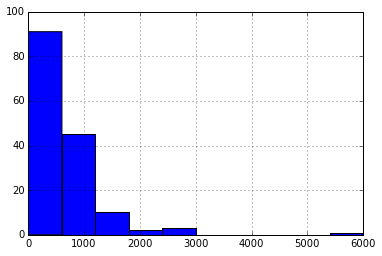

In [118]:
interpolated_2['sche_h_sec'].hist()

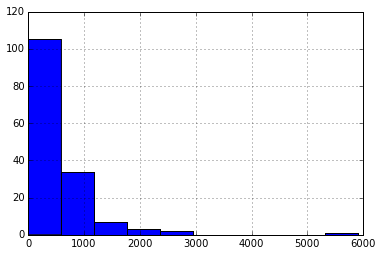

In [119]:
interpolated_2['inter_h_sec'].hist()

In [124]:
def peak_hour(x):
    if x > '06:00:00' and x < '09:00:00':
        return True
    else:
        if x > '16:00:00' and x < '19:00:00':
            return True
        else:
            return False

In [132]:
peak_hour(interpolated_2['arrival_time'][0])

False

In [141]:
interpolated_2['P_hour'] = map(lambda x:peak_hour(x),interpolated_2['arrival_time'])

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [144]:
interpolated_2['diff'] = interpolated_2['inter_h_sec'] - interpolated_2['sche_h_sec']

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [146]:
def wait_ass(x,y):
    if x == True:
        if y >= 3*60:
            return True
        else:
            return False
    if x == False:
        if y>= 5*60:
            return True
        else:
            return False         

In [147]:
wait_ass(interpolated_2['P_hour'][1],interpolated_2['diff'][1])

False

In [150]:
interpolated_2['wait_ass'] = map(lambda x,y:wait_ass(x,y), interpolated_2['P_hour'],interpolated_2['diff'])

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [166]:
interpolated_2

interpolated_arrival_time  \
route       trip_id                         trip_date  vehicle_id    stop_sequence stop_id                              
MTA NYCT_B1 UP_D5-Weekday-SDon-073300_B1_12 2015-12-03 MTA NYCT_4892 8             300009             12:21:25.050014   
            UP_D5-Weekday-SDon-106500_B1_43 2015-12-03 MTA NYCT_7172 8             300009             17:51:37.570228   
            UP_D5-Weekday-SDon-128900_B1_42 2015-12-03 MTA NYCT_4867 8             300009             21:32:51.901086   
            UP_D5-Weekday-SDon-090200_B1_35 2015-12-03 MTA NYCT_5118 8             300009             15:12:25.500396   
            UP_D5-Weekday-SDon-133000_B1_40 2015-12-03 MTA NYCT_4889 8             300009             22:14:03.766109   
            UP_D5-Weekday-SDon-064800_B1_26 2015-12-03 MTA NYCT_4984 8             300009             10:53:04.887698   
            UP_D5-Weekday-SDon-068800_B1_10 2015-12-03 MTA NYCT_4855 8             300009             11:31:05.282763   
            UP_D5-Weekday-SDon-085200_B1_9  2015-12-03 MTA NYCT_5082 8             300009             14:20:36.594470   
            UP_D5-Weekday-SDon-078500_B1_4  2015-12-03 MTA NYCT_4895 8             300009             13:13:42.668492   
            UP_D5-Weekday-SDon-085900_B1_19 2015-12-03 MTA NYCT_4858 8             300009             14:27:16.757267   
            UP_D5-Weekday-SDon-046800_B1_11 2015-12-03 MTA NYCT_4892 8             300009             07:55:29.962032   
            UP_D5-Weekday-SDon-131700_B1_37 2015-12-03 MTA NYCT_7141 8             300009             22:02:34.865548   
            UP_D5-Weekday-SDon-092800_B1_22 2015-12-03 MTA NYCT_4878 8             300009             15:31:26.518816   
            UP_D5-Weekday-SDon-006000_B1_1  2015-12-03 MTA NYCT_4877 8             300009             01:03:06.992515   
            UP_D5-Weekday-SDon-103000_B1_22 2015-12-03 MTA NYCT_4878 8             300009             17:19:40.620416   
            UP_D5-Weekday-SDon-110400_B1_37 2015-12-03 MTA NYCT_4988 8             300009             18:31:24.480812   
            UP_D5-Weekday-SDon-058800_B1_25 2015-12-03 MTA NYCT_4878 8             300009             10:42:16.037801   
            UP_D5-Weekday-SDon-100500_B1_24 2015-12-03 MTA NYCT_5115 8             300009             16:54:30.981040   
            UP_D5-Weekday-SDon-042300_B1_15 2015-12-03 MTA NYCT_4988 8             300009             07:12:32.764829   
            UP_D5-Weekday-SDon-038600_B1_4  2015-12-03 MTA NYCT_7179 8             300009             06:30:30.516852   
            UP_D5-Weekday-SDon-049800_B1_17 2015-12-03 MTA NYCT_5110 8             300009             08:24:23.417384   
            UP_D5-Weekday-SDon-097500_B1_33 2015-12-03 MTA NYCT_5096 8             300009             16:27:20.730280   
            UP_D5-Weekday-SDon-101500_B1_32 2015-12-03 MTA NYCT_5088 8             300009             17:05:20.284048   
            UP_D5-Weekday-SDon-106000_B1_21 2015-12-03 MTA NYCT_5085 8             300009             17:49:12.716163   
            UP_D5-Weekday-SDon-040600_B1_5  2015-12-03 MTA NYCT_7191 8             300009             06:48:21.654400   
            UP_D5-Weekday-SDon-137000_B1_38 2015-12-03 MTA NYCT_4876 8             300009             22:52:03.448198   
            UP_D5-Weekday-SDon-076700_B1_20 2015-12-03 MTA NYCT_4984 8             300009             12:59:15.279702   
            UP_D5-Weekday-SDon-081100_B1_9  2015-12-03 MTA NYCT_5082 8             300009             13:39:35.515672   
            UP_D5-Weekday-SDon-090600_B1_20 2015-12-03 MTA NYCT_4984 8             300009             15:14:32.180252   
            UP_D5-Weekday-SDon-086700_B1_32 2015-12-03 MTA NYCT_5088 8             300009             14:37:30.611898   
...                                                                                                               ...   
            UP_D5-Weekday-SDon-083000_B1_24 2015-12-03 MTA NYCT_5115 8             300009          

In [165]:
##wait assessment for the single route on the single stop
interpolated_2['wait_ass'].sum()/len(interpolated_2['wait_ass'])

0.10457516339869281